# Greedy Algorithm Benchmarking (For Uniform Bootstrapping)

This notebook serves to benchmark VanillaGreedySolver with our missing data imputation function that utilize uniform bootstrapping.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/).

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import random

import cassiopeia as cas

## Building benchmarking pipeline

The benchmarking pipeline consists of:

1. Simulating a ground truth phylogeny
2. Overlaying data onto this phylogeny
3. Inferring the phylogeny with potentially many algorithms
4. Assessing performance

Setting up necessary variables
- `algorithm` = The algorithms we will compare
- `bd_sim` = Simulates a birth-death process for creating a ground truth tree
- `lt_sim` = Uses a Cas9-based lineage tracing data simulator for overlaying data

In [2]:
algorithms = {
    "Vanilla Greedy": cas.solver.VanillaGreedySolver(),
    "p=1": cas.solver.VanillaGreedySolver(),
    "p=0.75": cas.solver.VanillaGreedySolver(),
    "p=0.5": cas.solver.VanillaGreedySolver(),
    "p=0.25": cas.solver.VanillaGreedySolver(),
    "p=0": cas.solver.VanillaGreedySolver(),
    # can add more algorithms here
}

bd_sim = cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution=lambda scale: np.random.exponential(scale),
    initial_birth_scale=0.5,
    death_waiting_distribution=lambda: np.random.exponential(1.5),
    mutation_distribution=lambda: 1 if np.random.uniform() < 0.5 else 0,
    fitness_distribution=lambda: np.random.normal(0, 0.5),
    fitness_base=1.3,
    num_extant=400,
    random_seed=17,
)

np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes=40,
    size_of_cassette=1,
    mutation_rate=0.1,
    state_generating_distribution=lambda: np.random.exponential(1e-5),
    number_of_states=50,
    state_priors=None,
    heritable_silencing_rate=9e-4,
    stochastic_silencing_rate=0.1,
    heritable_missing_data_state=-1,
    stochastic_missing_data_state=-1,
)

In [3]:
# Main Benchmark Code


def generate_character_matrix(character_matrix, impute):
    character_matrix_copy = character_matrix.copy(deep=True)

    num_row, num_col = character_matrix_copy.shape

    for c in range(num_col):
        cutsite_mut_distr = list(
            filter(lambda x: x != -1, character_matrix[c].tolist())
        )
        for r in range(num_row):
            if random.random() <= impute:
                if character_matrix_copy[c][r] == -1:
                    character_matrix_copy[c][r] = random.choice(cutsite_mut_distr)

    return character_matrix_copy

iterations = 10
algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)

for _ in tqdm(range(iterations)):
    ground_truth_tree = bd_sim.simulate_tree()

    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)

    for algorithm_name in tqdm(algorithms.keys()):
        algorithm = algorithms[algorithm_name]
        cm = ground_truth_tree.character_matrix
        if algorithm_name == "p=1":
            cm = generate_character_matrix(cm, 1)
        if algorithm_name == "p=0.75":
            cm = generate_character_matrix(cm, 0.75)
        if algorithm_name == "p=0.5":
            cm = generate_character_matrix(cm, 0.5)
        if algorithm_name == "p=0.25":
            cm = generate_character_matrix(cm, 0.25)
        if algorithm_name == "p=0":
            cm = generate_character_matrix(cm, 0)

        reconstructed_tree = cas.data.CassiopeiaTree(
            character_matrix=cm,
            missing_state_indicator=-1,
        )

        algorithm.solve(reconstructed_tree)

        # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters=True)

        rf, rf_max = cas.critique.compare.robinson_foulds(
            ground_truth_tree, reconstructed_tree
        )

        triplets = cas.critique.compare.triplets_correct(
            ground_truth_tree, reconstructed_tree, number_of_trials=500
        )
        algorithm_to_performance_triplets[algorithm_name].append(
            np.mean(list(triplets[0].values()))
        )

        algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

**Visualising Results**

We will visualize the results by looking at two metrics offered by the Cassiopeia `critique` library:

- Triplets Correct Measure
- Robinson-Foulds Distance

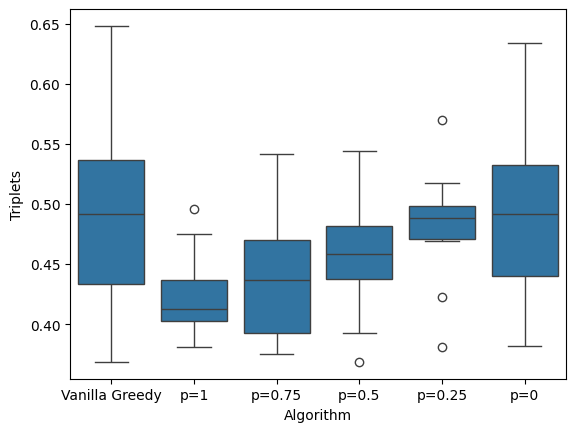

                count      mean       std       min       25%       50%  \
Algorithm                                                                 
Vanilla Greedy   10.0  0.495711  0.087142  0.368556  0.433583  0.491944   
p=0              10.0  0.495222  0.079823  0.381889  0.439917  0.491778   
p=0.25           10.0  0.480300  0.051176  0.380778  0.470528  0.488222   
p=0.5            10.0  0.457556  0.052527  0.368889  0.437778  0.458500   
p=0.75           10.0  0.441256  0.057042  0.374889  0.392472  0.437111   
p=1              10.0  0.424667  0.037016  0.381333  0.402361  0.412944   

                     75%       max  
Algorithm                           
Vanilla Greedy  0.536806  0.648222  
p=0             0.532139  0.633667  
p=0.25          0.498472  0.570333  
p=0.5           0.481389  0.543889  
p=0.75          0.470361  0.541222  
p=1             0.437083  0.496111  


In [4]:
# Triplets Correct Measure
algorithm_to_performance_triplets_df = pd.DataFrame(columns=["Algorithm", "Triplets"])
for algorithm in algorithm_to_performance_triplets:
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["Triplets"] = entries

    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])

sns.boxplot(data=algorithm_to_performance_triplets_df, x="Algorithm", y="Triplets")
plt.show()

triplets_stats = algorithm_to_performance_triplets_df.groupby("Algorithm")["Triplets"].describe()
print(triplets_stats)

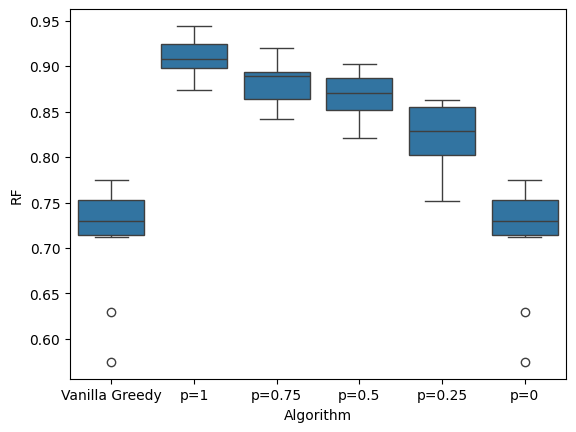

                count      mean       std       min       25%       50%  \
Algorithm                                                                 
Vanilla Greedy   10.0  0.712683  0.062633  0.574751  0.714058  0.729202   
p=0              10.0  0.712683  0.062633  0.574751  0.714058  0.729202   
p=0.25           10.0  0.824197  0.036214  0.751987  0.802281  0.829103   
p=0.5            10.0  0.867349  0.025141  0.820755  0.851378  0.870516   
p=0.75           10.0  0.883143  0.026159  0.841322  0.863385  0.888847   
p=1              10.0  0.909845  0.019864  0.873817  0.897364  0.908333   

                     75%       max  
Algorithm                           
Vanilla Greedy  0.753094  0.774697  
p=0             0.753094  0.774697  
p=0.25          0.854795  0.862306  
p=0.5           0.886646  0.901861  
p=0.75          0.893416  0.920255  
p=1             0.923915  0.944171  


In [5]:
# Robinson-Foulds Distance
algorithm_to_performance_rf_df = pd.DataFrame(columns=["Algorithm", "RF"])
for algorithm in algorithm_to_performance_rf:
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["RF"] = entries

    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

sns.boxplot(data=algorithm_to_performance_rf_df, x="Algorithm", y="RF")
plt.show()

rf_stats = algorithm_to_performance_rf_df.groupby("Algorithm")["RF"].describe()
print(rf_stats)